# Trabalho de INF 791 - Redes Complexas
Paula Teresa Mota Gibrim
<b>Matrícula:</b> ES 90366

## Introdução
O trabalho prático, inicialmente, consistia do uso de APIs para captação de dados e então, modelagem do grafo usando NetworkX. Infelizmente, tive muita dificuldade para captação desses dados. A ideia inicial era coletar dados do Twitter de usuários que acompanharam a semi-final do campeonato mundial de Counter-Strike: Global Offensive, o IEM Rio 2022, partida entre Fúria e Heroic, e analisar novas conexões entre esses usuários após a partida. Todavia, após modificações das políticas de uso da API não permitiam mais a busca de tweets por palavras-chave (e todas as modificações que consegui moldar do problema, eu obtive o mesmo resultado).

[Aqui você visualiza o resultado das buscas](https://cdn.discordapp.com/attachments/1019674912333504614/1108094286978875522/image.png)

Diante disso, tentei solicitar acesso à API para Projetos Estudantis, que requer um tempo maior de análise, e não obtive resposta. Solicitei também a API do TikTok, mas demoraram 3 semanas para dar um retorno, e o mesmo foi negativo. Tentei buscar outras APIs, e todas tinham os mesmos problemas: não faziam nenhuma coleta de dados da rede, mas sim do usuário.

Analisando essa situação, optei por avançar no trabalho sem coletar meus próprios dados, utilizando um dataset já coletado e fazendo a modelagem em cima dele. Sendo assim, o dataset escolhido visa medir a probabilidade de conectividade entre usuários de diferentes países, considerando os dados de usuários do Facebook.

## Rede analisada
O dataset selecionado é baseado em dados anônimos coletados no Facebook. Cada usuário é atribuído a um país baseado nas informações disponibilizadas em seu perfil, e de conexões de seus dispositivos. Diante disso, o SCI (Social Connectedness Index) entre dois locais <i>i</i> e <i>j</i> é calculado como:
$$
    SCI_{i,j} = \frac{\textrm{FB_Connections}_{i,j}}{\textrm{FB_Users}_{i} \times \textrm{FB_Users}_{j}}
$$
onde $\textrm{FB_Users}_{i}$ e $\textrm{FB_Users}_{j}$ se referem à quantidade de usuários do Facebook no país <i>i</i> e <i>j</i>, e $\textrm{FB_Connections}_{i,j}$ é o número total de conexões entre indivíduos desses dois países.

## O código

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('data.tsv', sep='\t')

# Criar o grafo
graph = nx.Graph()
user_loc_list = data['user_loc'].tolist()
fr_loc_list = data['fr_loc'].tolist()
scaled_sci_list = data['scaled_sci'].tolist()

graph.add_nodes_from(user_loc_list)
for i in range(0, len(user_loc_list)):
    graph.add_edge(user_loc_list[i], fr_loc_list[i], weight=scaled_sci_list[i])
# # Exportando para o Gephi
# nx.write_gexf(graph, "graph.gexf")

## Análise da rede

### Calcular e plotar o grau dos nodos do grafo:

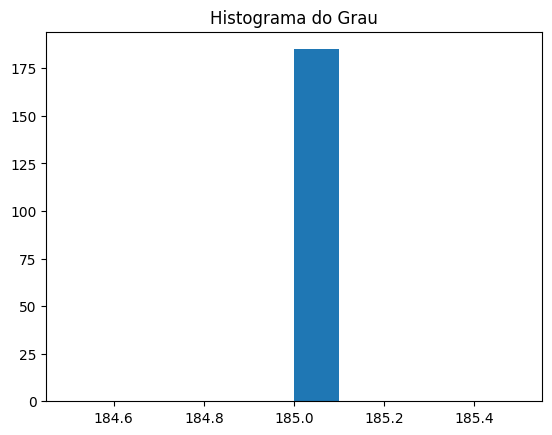

In [27]:
degree = {}
x = []
for node in graph.nodes:
    degree[node] = len(graph.adj[node])
    x.append(degree[node])

plt.hist(x)
plt.title("Histograma do Grau")
plt.show()

Sendo assim, temos todos os vértices com grau 185, de modo que o grau médio do grafo também é 185. De fato, como o grafo é um grafo completo, ou seja, todos os países têm conexões com os outros países (mesmo que pequena), o grau será o mesmo que o número de nós do grafo.

### Calcular número de componentes conexos
Como o grafo é completo, conseguimos acessar qualquer nó a partir de qualquer outro. Sendo assim, o grafo tem apenas 1 componente conexo. O cálculo é descrito abaixo, usando Depth First Search:

In [28]:
def dfs(node):
    if wasVisited[node]:
        return
    else:
        wasVisited[node] = True
        for neighbor in graph.adj[node]:
            if not(wasVisited[neighbor]):
                dfs(neighbor)

wasVisited = {}

for node in graph.nodes:
    wasVisited[node] = False

conex = 0
for node in graph.nodes:
    if not(wasVisited[node]):
        dfs(node)
        conex += 1

print(conex)

1


### Calcular o coeficiente de clusterização e plotar
Para calcular o coeficiente de clusterização de um grafo não-direcionado, basta fazer o seguinte cálculo:

$$
CC_i = \frac{\textrm{#conexões não-direcionadas entre os vizinhos de i}}{n_i * \frac{(n_i -1)}{2}}
$$

In [29]:
# Código para achar a intersecção de duas listas (Geeks for Geeks)
# Link: https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

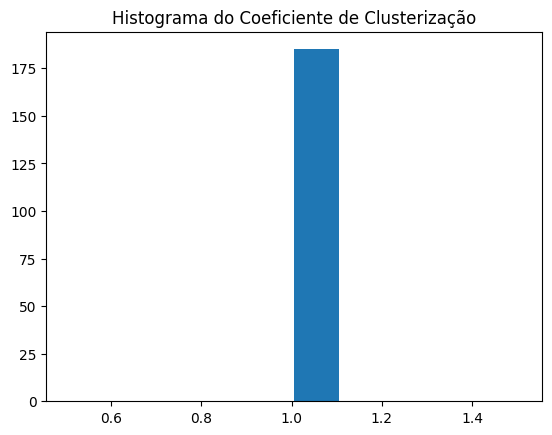

In [30]:
cc = {}
x = []

# Para garantir que o set do coeficiente de clusterização inicie vazio
for node in graph.nodes:
    cc[node] = 0

# Calcular o número de intersecções
for node in graph.nodes:
    for neighbor in graph.adj[node]:
        intersec = intersection(graph.adj[node], graph.adj[neighbor])
        cc[node] += len(intersec)

# Como cada intersecção é calculada 2 vezes, basta dividir o valor encontrado por 2, e então fazer o cálculo
for node in graph.nodes:
    cc[node] /= 2
    cc[node] /= (degree[node] * (degree[node] -1)/2)
    x.append(cc[node])

plt.hist(x)
plt.title("Histograma do Coeficiente de Clusterização")
plt.show()

Sendo assim, temos todos os coeficientes de clusterização com valor 1, de modo que o coeficiente de clusterização global do grafo também é 1.

### Calcular o overlap dos nodos
Para calcular o overlap de cada nodo, basta fazer:
$$
O_{i,j} = \frac{\textrm{neighbor}_i \cap \textrm{neighbor}_j}{\textrm{neighbor}_i \cup \textrm{neighbor}_j}
$$

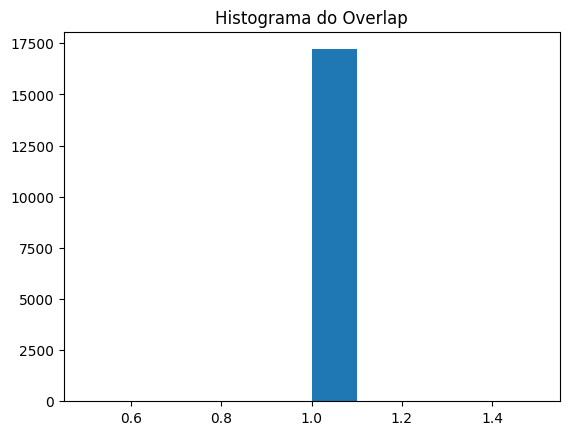

In [31]:
overlap = {}
x = []

# Para que cada par de vértices não seja calculado duas vezes, vamos fazer:
for node in graph.nodes:
    for neighbor in graph.adj[node]:
        overlap[node,neighbor] = -1
        overlap[neighbor,node] = -1

for node in graph.nodes:
    for neighbor in graph.adj[node]:
        if overlap[node,neighbor] == -1:
            intersec = intersection(graph.adj[node], graph.adj[neighbor])
            union = set(graph.adj[node]) or set(graph.adj[neighbor])
            overlap[node,neighbor] = len(intersec)/len(union)
            overlap[neighbor,node] = len(intersec)/len(union)
            x.append(overlap[node, neighbor])

plt.hist(x)
plt.title("Histograma do Overlap")
plt.show()

### Calcular a distância média e a distribuição de distâncias de todos os nodos da rede
Para calcular a distância média, é necessário saber a distância entre um nó $n$ e todos os outros nós. Como o grafo analizado é completo, temos que a distância entre quaisquer nós é $1$, e assim, a distância média também é $1$. O cálculo, usando Busca em Largura (BFS) é descrito abaixo:

TypeError: '<=' not supported between instances of 'int' and 'NoneType'

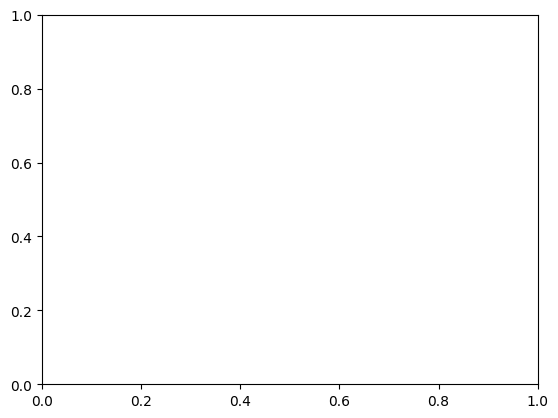

In [33]:
def bfs(node, destiny):
    if node == destiny:
        return 0

    wasVisited = {}

    # Marcar todos os nós como não visitados
    for node in graph.nodes:
        wasVisited[node] = False

    # Criar a queue para a busca
    queue = []
    queue.append((node, 0))
    wasVisited[node] = True

    while queue:
        node = queue[0][0]
        aux = queue[0][1]
        queue.pop(0)

        for neighbor in graph.adj[node]:
            if neighbor == destiny:
                return aux + 1
            if not wasVisited[neighbor]:
                wasVisited[neighbor] = True
                queue.append((neighbor, aux+1))

distance = {}
x = []

# Para que cada par de vértices não seja calculado duas vezes, vamos fazer:
for node in graph.nodes:
    for neighbor in graph.adj[node]:
        distance[(node,neighbor)] = -1
        distance[(neighbor,node)] = -1

count = 0
for node in graph.nodes:
    count += 1
    for neighbor in graph.adj[node]:
        if distance[(node, neighbor)] == -1:
            aux = bfs(node, neighbor)
            distance[(node, neighbor)] = aux
            distance[(neighbor, node)] = aux
            x.append(aux)
plt.hist(x)
plt.title("Histograma das Distâncias")
plt.show()